In [26]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

2024-09-02 23:20:12 law_school_gpa_dataset.py WARNING : No module named 'tempeh': LawSchoolGPADataset will be unavailable. To install, run:
pip install 'aif360[LawSchoolGPA]'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

# Multiple Models With DB Writer Interface

In this example, we are going to conduct a deep performance profiling for 4 models. For that, we will use `compute_metrics_with_db_writer` interface that will compute metrics for multiple models and save results in the user database based on the _db_writer_ function. Thus, we will need to do the next steps:

* Initialize input variables

* Compute subgroup metrics

* Perform disparity metrics composition using the Metric Composer

* Create static visualizations using the Metric Visualizer

## Import dependencies

In [28]:
import os
import pandas as pd

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from virny.user_interfaces.multiple_models_with_db_writer_api import compute_metrics_with_db_writer
from virny.utils.custom_initializers import create_config_obj, create_models_metrics_dct_from_database_df
from virny.custom_classes.metrics_visualizer import MetricsVisualizer
from virny.custom_classes.metrics_composer import MetricsComposer
from virny.preprocessing.basic_preprocessing import preprocess_dataset
from virny.datasets import CompasWithoutSensitiveAttrsDataset

## Initialize Input Variables

Based on the library flow, we need to create 3 input objects for a user interface:

* A **config yaml** that is a file with configuration parameters for different user interfaces for metric computation.

* A **dataset class** that is a wrapper above the user’s raw dataset that includes its descriptive attributes like a target column, numerical columns, categorical columns, etc. This class must be inherited from the BaseDataset class, which was created for user convenience.

* Finally, a **models config** that is a Python dictionary, where keys are model names and values are initialized models for analysis. This dictionary helps conduct audits for different analysis modes and analyze different types of models.

In [29]:
TEST_SET_FRACTION = 0.2
DATASET_SPLIT_SEED = 42

### Create a config object

`compute_metrics_with_db_writer` interface requires that your **yaml file** includes the following parameters:

* **dataset_name**: str, a name of your dataset; it will be used to name files with metrics.

* **bootstrap_fraction**: float, the fraction from a train set in the range [0.0 - 1.0] to fit models in bootstrap (usually more than 0.5).

* **random_state**: int, a seed to control the randomness of the whole model evaluation pipeline.

* **n_estimators**: int, the number of estimators for bootstrap to compute subgroup stability metrics.

* **sensitive_attributes_dct**: dict, a dictionary where keys are sensitive attribute names (including intersectional attributes), and values are disadvantaged values for these attributes. Intersectional attributes must include '&' between sensitive attributes. You do not need to specify disadvantaged values for intersectional groups since they will be derived from disadvantaged values in sensitive_attributes_dct for each separate sensitive attribute in this intersectional pair.

Note that disadvantaged value in a sensitive attribute dictionary must be **the same as in the original dataset**. For example, when distinct values of the _sex_ column in the original dataset are 'F' and 'M', and after pre-processing they became 0 and 1 respectively, you still need to set a disadvantaged value as 'F' or 'M' in the sensitive attribute dictionary.


In [30]:
ROOT_DIR = os.getcwd()
config_yaml_path = os.path.join(ROOT_DIR, 'experiment_config.yaml')
config_yaml_content = \
"""dataset_name: COMPAS_Without_Sensitive_Attributes
bootstrap_fraction: 0.8
random_state: 42
n_estimators: 50  # Better to input the higher number of estimators than 100; this is only for this use case example
sensitive_attributes_dct: {'sex': 1, 'race': 'African-American', 'sex&race': None}
"""

with open(config_yaml_path, 'w', encoding='utf-8') as f:
    f.write(config_yaml_content)

In [31]:
config = create_config_obj(config_yaml_path=config_yaml_path)

### Create a Dataset class

Based on the BaseDataset class, your **dataset class** should include the following attributes:

* **Obligatory attributes**: dataset, target, features, numerical_columns, categorical_columns

* **Optional attributes**: X_data, y_data, columns_with_nulls

For more details, please refer to the library documentation.

In [32]:
data_loader = CompasWithoutSensitiveAttrsDataset()
data_loader.X_data[data_loader.X_data.columns[:5]].head()

,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat_25 - 45
0,0.0,-2.340451,1.0,-15.010999,1
1,0.0,0.000000,0.0,0.000000,1
2,0.0,0.000000,0.0,0.000000,0
3,0.0,0.000000,0.0,6.000000,1
4,0.0,0.000000,0.0,7.513697,1


In [33]:
column_transformer = ColumnTransformer(transformers=[
    ('categorical_features', OneHotEncoder(handle_unknown='ignore', sparse_output=False), data_loader.categorical_columns),
    ('numerical_features', StandardScaler(), data_loader.numerical_columns),
])

In [34]:
base_flow_dataset = preprocess_dataset(data_loader=data_loader,
                                       column_transformer=column_transformer,
                                       sensitive_attributes_dct=config.sensitive_attributes_dct,
                                       test_set_fraction=TEST_SET_FRACTION,
                                       dataset_split_seed=DATASET_SPLIT_SEED)

### Create a models config

**models_config** is a Python dictionary, where keys are model names and values are initialized models for analysis

In [35]:
models_config = {
    'DecisionTreeClassifier': DecisionTreeClassifier(criterion='gini',
                                                     max_depth=20,
                                                     max_features=0.6,
                                                     min_samples_split=0.1),
    'LogisticRegression': LogisticRegression(C=1,
                                             max_iter=50,
                                             penalty='l2',
                                             solver='newton-cg'),
    'RandomForestClassifier': RandomForestClassifier(max_depth=4,
                                                     max_features=0.6,
                                                     min_samples_leaf=1,
                                                     n_estimators=50),
    'XGBClassifier': XGBClassifier(learning_rate=0.1,
                                   max_depth=5,
                                   n_estimators=20),
}

## Subgroup Metric Computation

After that we need to input the _BaseFlowDataset_ object, models config, and config yaml to a metric computation interface and execute it. The interface uses subgroup analyzers to compute different sets of metrics for each privileged and disadvantaged group. As for now, our library supports **Subgroup Variance Analyzer** and **Subgroup Error Analyzer**, but it is easily extensible to any other analyzers. When the variance and error analyzers complete metric computation, their metrics are combined, returned in a matrix format, and stored in the user defined database using the input _db_writer_ function.

In [36]:
import os
from dotenv import load_dotenv
from pymongo import MongoClient


load_dotenv(os.path.join(ROOT_DIR, 'secrets.env'))  # Take environment variables from .env

# Provide the mongodb atlas url to connect python to mongodb using pymongo
CONNECTION_STRING = os.getenv("CONNECTION_STRING")
# Create a connection using MongoClient. You can import MongoClient or use pymongo.MongoClient
client = MongoClient(CONNECTION_STRING)
collection = client[os.getenv("DB_NAME")]['preprocessing_results']


def db_writer_func(run_models_metrics_df, collection=collection):
    run_models_metrics_df.columns = run_models_metrics_df.columns.str.lower()  # Rename Pandas columns to lower case
    collection.insert_many(run_models_metrics_df.to_dict('records'))

In [37]:
import uuid

custom_table_fields_dct = {
    'session_uuid': str(uuid.uuid4()),
    'preprocessing_techniques': 'get_dummies and scaler',
}
print('Current session uuid: ', custom_table_fields_dct['session_uuid'])

Current session uuid:  39e822c3-4aa4-424f-a052-bce799a0ac05


In [38]:
metrics_dct = compute_metrics_with_db_writer(base_flow_dataset, config, models_config, custom_table_fields_dct, db_writer_func,
                                             notebook_logs_stdout=True)

Analyze multiple models:   0%|          | 0/4 [00:00<?, ?it/s]

Classifiers testing by bootstrap:   0%|          | 0/50 [00:00<?, ?it/s]

Classifiers testing by bootstrap:   0%|          | 0/50 [00:00<?, ?it/s]

Classifiers testing by bootstrap:   0%|          | 0/50 [00:00<?, ?it/s]

Classifiers testing by bootstrap:   0%|          | 0/50 [00:00<?, ?it/s]

Look at several columns in top rows of computed metrics

In [39]:
sample_model_metrics_df = metrics_dct[list(models_config.keys())[0]]
sample_model_metrics_df[sample_model_metrics_df.columns[:6]].head(20)

,Metric,overall,sex_priv,sex_dis,race_priv,race_dis
0,Std,0.073404,0.076654,0.072593,0.073483,0.073353
1,Mean_Prediction,0.519733,0.575657,0.505768,0.585374,0.477403
2,Statistical_Bias,0.416691,0.413261,0.417548,0.412091,0.419658
3,IQR,0.087474,0.088773,0.087150,0.089656,0.086067
4,Overall_Uncertainty,0.887649,0.898580,0.884919,0.882318,0.891086
5,Aleatoric_Uncertainty,0.859615,0.866990,0.857773,0.853026,0.863864
6,Epistemic_Uncertainty,0.028034,0.031589,0.027146,0.029292,0.027223
7,Label_Stability,0.862917,0.827488,0.871763,0.859614,0.865047
8,Jitter,0.108416,0.130465,0.102910,0.107781,0.108826
9,TPR,0.656051,0.493333,0.686869,0.517007,0.719136


## Disparity Metric Composition

To compose disparity metrics, the Metric Composer should be applied. **Metric Composer** is responsible for the second stage of the model audit. Currently, it computes our custom error disparity, stability disparity, and uncertainty disparity metrics, but extending it for new disparity metrics is very simple. We noticed that more and more disparity metrics have appeared during the last decade, but most of them are based on the same group specific metrics. Hence, such a separation of group specific and disparity metrics computation allows us to experiment with different combinations of group specific metrics and avoid group metrics recomputation for a new set of disparity metrics.

In [40]:
def read_model_metric_dfs_from_db(collection, session_uuid):
    cursor = collection.find({'session_uuid': session_uuid})
    records = []
    for record in cursor:
        del record['_id']
        records.append(record)

    model_metric_dfs = pd.DataFrame(records)

    # Capitalize column names to be consistent across the whole library
    new_column_names = []
    for col in model_metric_dfs.columns:
        new_col_name = '_'.join([c.capitalize() for c in col.split('_')])
        new_column_names.append(new_col_name)

    model_metric_dfs.columns = new_column_names
    return model_metric_dfs

In [41]:
model_metric_dfs = read_model_metric_dfs_from_db(collection, custom_table_fields_dct['session_uuid'])
models_metrics_dct = create_models_metrics_dct_from_database_df(model_metric_dfs)

In [42]:
metrics_composer = MetricsComposer(models_metrics_dct, config.sensitive_attributes_dct)

Compute composed metrics

In [43]:
models_composed_metrics_df = metrics_composer.compose_metrics()

## Metric Visualization

**Metric Visualizer** allows us to build static visualizations for the computed metrics. It unifies different preprocessing methods for the computed metrics and creates various data formats required for visualizations. Hence, users can simply call methods of the MetricsVisualizer class and get custom plots for diverse metric analysis.

In [44]:
visualizer = MetricsVisualizer(models_metrics_dct, models_composed_metrics_df, config.dataset_name,
                               model_names=list(models_config.keys()),
                               sensitive_attributes_dct=config.sensitive_attributes_dct)

In [45]:
visualizer.create_overall_metrics_bar_char(
    metric_names=['Accuracy', 'F1', 'TPR', 'TNR', 'PPV', 'Selection-Rate'],
    plot_title="Accuracy Metrics"
)

alt.Chart(...)

In [46]:
visualizer.create_overall_metrics_bar_char(
    metric_names=['Aleatoric_Uncertainty', 'Overall_Uncertainty', 'Label_Stability', 'Std', 'IQR', 'Jitter'],
    plot_title="Stability and Uncertainty Metrics"
)

alt.Chart(...)

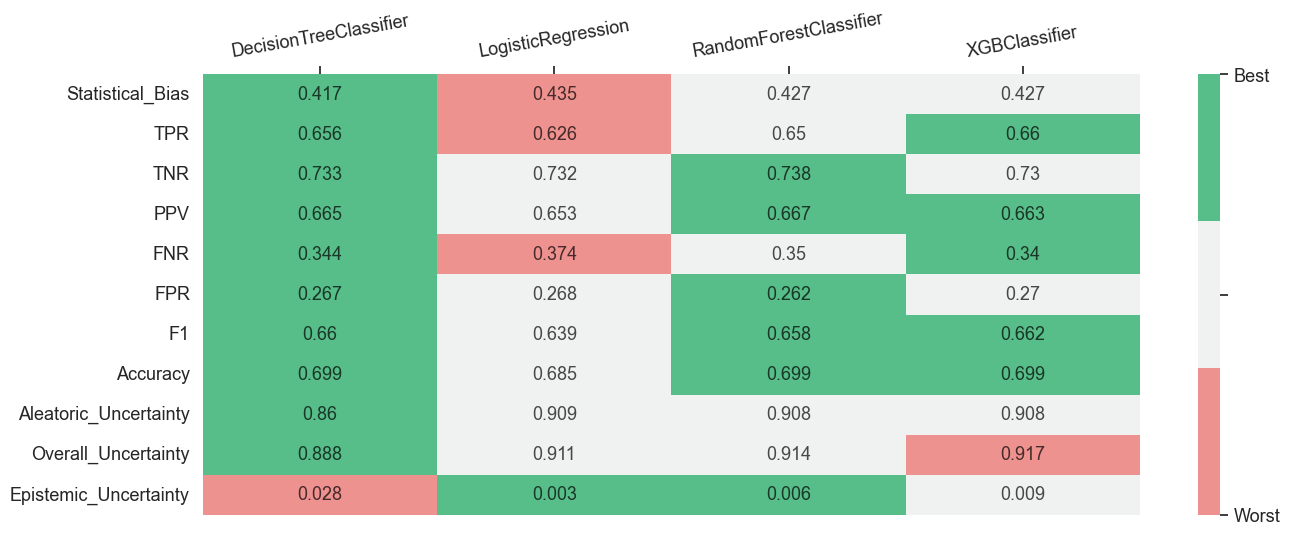

In [47]:
visualizer.create_overall_metric_heatmap(
    model_names=list(models_config.keys()),
    metrics_lst=visualizer.all_accuracy_metrics + visualizer.all_uncertainty_metrics,
    tolerance=0.005,
)

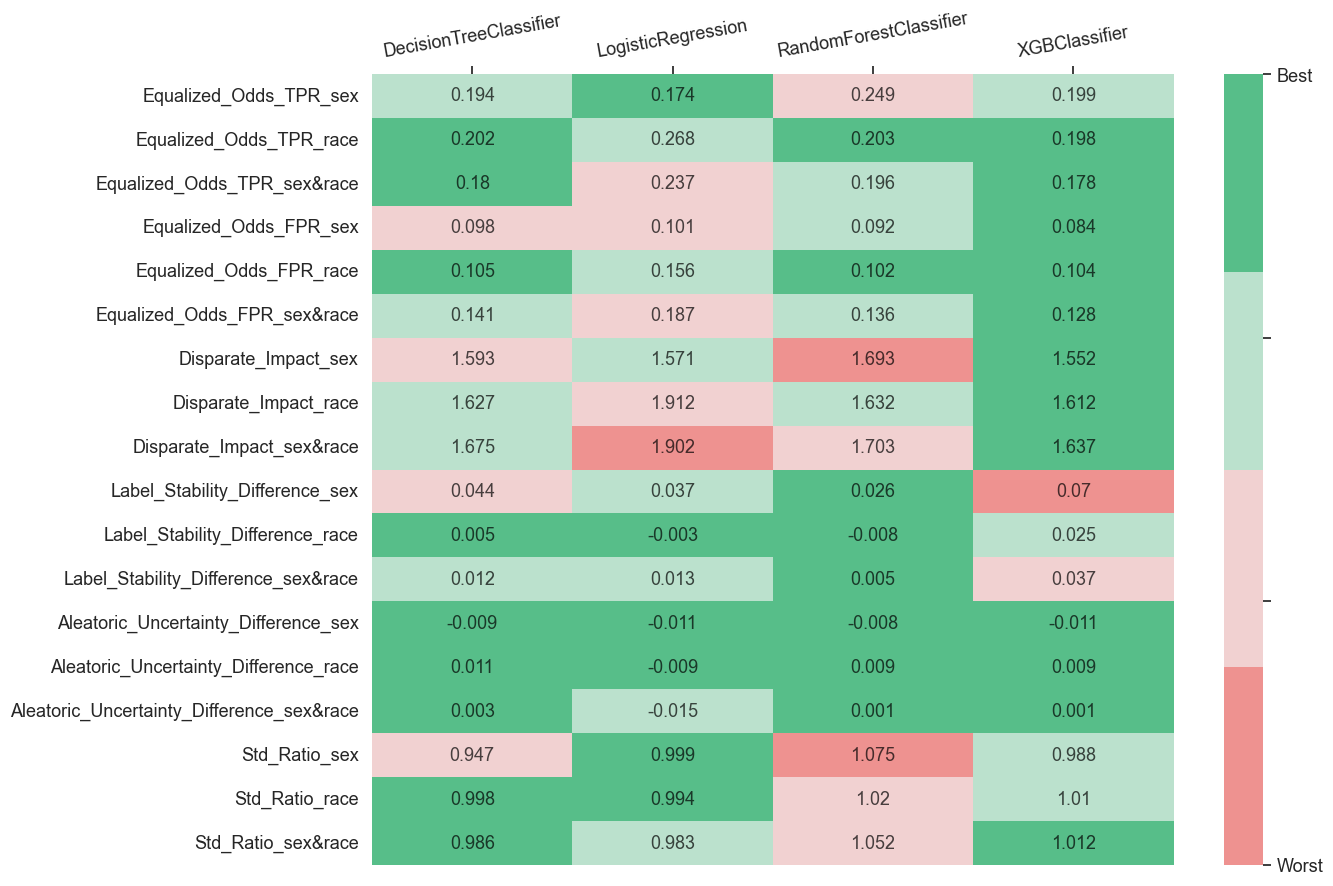

In [48]:
visualizer.create_disparity_metric_heatmap(
    model_names=list(models_config.keys()),
    metrics_lst=[
        # Error disparity metrics
        'Equalized_Odds_TPR',
        'Equalized_Odds_FPR',
        'Disparate_Impact',
        # Stability disparity metrics
        'Label_Stability_Difference',
        'Aleatoric_Uncertainty_Difference',
        'Std_Ratio',
    ],
    groups_lst=config.sensitive_attributes_dct.keys(),
    tolerance=0.005,
)

In [49]:
client.close()